In [1]:
# Packages

import freenect
import cv2
import numpy as np
from numba import njit, prange
import math
import os
import re
import sys
import time
import pickle
from pathlib import Path
import tifffile as tiff
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib import animation, rc
rc('animation', html='jshtml')

from IPython.display import HTML
from collections import deque
from tqdm.notebook import tqdm
from behavior_functions import *
from hmmlearn import hmm

from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, median_filter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection

colors = {'blue':'#59D0FF', 'orange':'#FFA81C', 'purple':'#B482FF', 'red':'#FF5E5E', 'green':'#71F66D', 'pink':'#EFAAEC', 'gray':'#999999', 'black': '#434343', 'yellow': '#EEE30C', 'turquoise': '#5DF1D9', 'darkblue': '#495FFC', 'palegray': '#D7D7D7'}

In [2]:
# Behavior folder in which all sessions are.

behavior_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior"

# session_keywords and mouse_keywords are lists of form ['S1', 'S2', 'S5'] or ['M29', 'M33', 'M37'], respectively.
# It can also be "all" if all sessions and mice are selected for analysis.
session_keywords = ['S1', "S2", 'S3', 'S4', 'S5', 'S6']
mouse_keywords = ['M28', 'M29', 'M31', 'M33', 'M34', 'M35', 'M39', 'M40', 'M41', 'M42', 'M44']

#conversion factor for x and y scale in arena (5.77 pixel per cm)
pixel_cm = 5.77

dataset_list = dataset_paths(behavior_path, session_keywords, mouse_keywords, verbose = True)
print("Number of datasets: " ,len(dataset_list))

Mouse keywords:  ['M28', 'M29', 'M31', 'M33', 'M34', 'M35', 'M39', 'M40', 'M41', 'M42', 'M44']
Session keywords:  ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
Number of datasets:  51


In [3]:
# Stack is the full set of coordinates as an array of dim (t,3,n).
#    t is length of timeseries
#    3 accounts for the three needed dimensions
#    n is the number of datasets

# Pad is an array of dim (n) that records the number of padded (positive pad) or cropped (negative pad)
# datapoints for stack to be of the same length. Pad can be used to discredit datasets or to normalize
# them if kept.
#    n is the number of datasets

session_stack, session_datainfo = open_coords(dataset_list, order='session_ordered', verbose = True, remove_tuples=[('S1', 'M34'), ('S1', 'M35')])
mouse_stack, mouse_datainfo = open_coords(dataset_list, order='mouse_ordered', verbose = False)

BH_M39_S2 is too short. It's 1226 values shorter than normal.


# NOR

In [152]:
# OB new -> M37 M39 M44 M46 M47
# RM new -> M38 M42 M45 M49 M50

#in order of OB_new to RM_new and in tuple order of (familiar, new)
train_24 = [(75,66), (22,43), (24,25), (18,11), (43,46), (41,43), (59,71), (40,45), (49,38), (74,96)] 
test_24 = [(12,16), (4,11), (3,7), (3,6), (1,10), (5,9), (4,5), (0,5), (10,4), (10,15)]

train_2w = [(65,85), (37,32), (47,74), (51,47), (38,43), (53,41), (20,18), (34,42), (32,32), (42,29)] 
test_2w = [(15,8), (6,3), (1,3), (5,5), (5,3), (5,7), (3,2), (10,9), (2,4), (2,6)] 

train_ratio_24 = exploration_ratio(train_24)
test_ratio_24 = exploration_ratio(test_24)

train_ratio_2w = exploration_ratio(train_2w)
test_ratio_2w = exploration_ratio(test_2w)

In [66]:
def exploration_ratio(data):

    ratios = []
    
    for familiar, new in data:
        total = familiar + new
        if total > 0:
            ratios.append((familiar / total, new / total))
        else:
            ratios.append((0, 0))  # In case of zero division, return (0, 0)
    
    return ratios

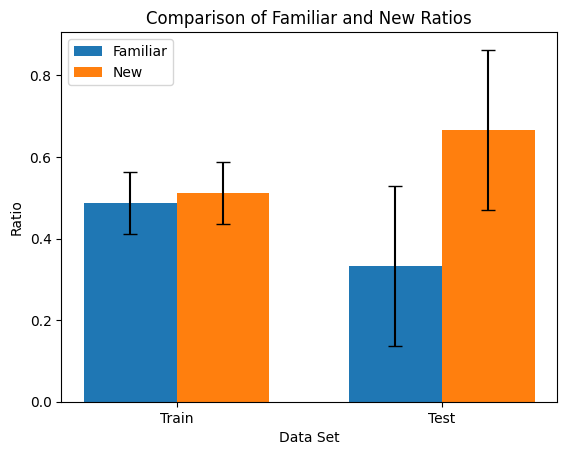

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and standard deviation for familiar and new ratios
def calculate_stats(ratios):
    familiar_ratios = [r[0] for r in ratios]
    new_ratios = [r[1] for r in ratios]
    
    familiar_mean = np.mean(familiar_ratios)
    familiar_std = np.std(familiar_ratios, ddof=1)
    
    new_mean = np.mean(new_ratios)
    new_std = np.std(new_ratios, ddof=1)
    
    return (familiar_mean, familiar_std), (new_mean, new_std)

# Get stats for train and test data
train_stats = calculate_stats(train_ratio_24)
test_stats = calculate_stats(test_ratio_24)

# Prepare data for plotting
labels = ['Train', 'Test']
familiar_means = [train_stats[0][0], test_stats[0][0]]
familiar_stds = [train_stats[0][1], test_stats[0][1]]
new_means = [train_stats[1][0], test_stats[1][0]]
new_stds = [train_stats[1][1], test_stats[1][1]]

# Plotting
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, familiar_means, width, yerr=familiar_stds, label='Familiar', capsize=5)
bar2 = ax.bar(x + width/2, new_means, width, yerr=new_stds, label='New', capsize=5)

# Adding labels and title
ax.set_xlabel('Data Set')
ax.set_ylabel('Ratio')
ax.set_title('Comparison of Familiar and New Ratios')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

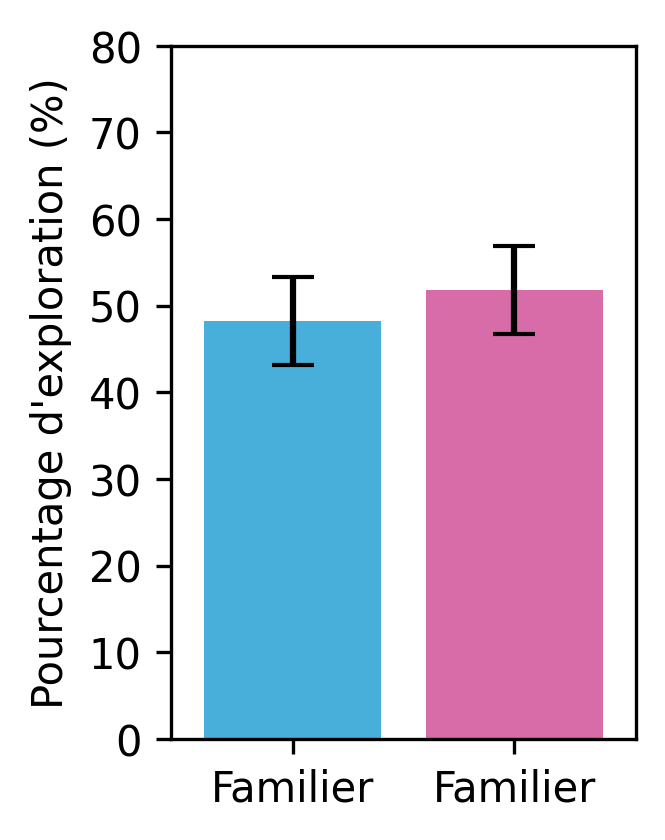

In [156]:
# Function to compute mean and standard error for familiar and new ratios
def calculate_stats(data):
    familiar_ratios = [r[0] / (r[0] + r[1]) for r in data]
    new_ratios = [r[1] / (r[0] + r[1]) for r in data]

    familiar_mean = np.mean(familiar_ratios)*100
    familiar_sem = 100*np.std(familiar_ratios, ddof=1) / np.sqrt(len(familiar_ratios))
    
    new_mean = np.mean(new_ratios)*100
    new_sem = 100*np.std(new_ratios, ddof=1) / np.sqrt(len(new_ratios))

    return (familiar_mean, familiar_sem), (new_mean, new_sem)


# Calculate statistics for the train data
train_stats = calculate_stats(test_2w)

# Prepare data for plotting
labels = ['Familier', 'Familier']
means = [train_stats[0][0], train_stats[1][0]]
sems = [train_stats[0][1], train_stats[1][1]]

# Plotting
fig, ax = plt.subplots(figsize=(2, 3), dpi=300)

x = [1,2]  # Label locations
width = 0.8  # Width of the bars

# Plot bars with error bars
ax.bar(x, means, width, yerr=sems, capsize=5, color=['#48AEDA','#D86CA8'])

# Adding labels and title
#ax.set_xlabel('Category')
ax.set_ylabel("Pourcentage d'exploration (%)")
#ax.set_title('Comparison of Familiar and New Ratios (Train Data)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 80])
ax.set_xlim([0.45, 2.55])

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/finished_figures/NOR_all_results/2w_test.svg')

In [ ]:
# Function to compute mean and standard error
def calculate_stats(data):
    first_mean = np.mean(data[:, 0])
    first_sem = np.std(data[:, 0], ddof=1)

    second_mean = np.mean(data[:, 1])
    second_sem = np.std(data[:, 1], ddof=1)

    return (first_mean, first_sem), (second_mean, second_sem)

# Calculate statistics
stats = calculate_stats(factor_OB_RM)

# Prepare data for plotting
labels = ['OB', 'RM']
means = [stats[0][0], stats[1][0]]
sems = [stats[0][1], stats[1][1]]

# Plotting
fig, ax = plt.subplots(figsize=(1.8, 3), dpi=300)

x = [0.5,1.4]
width = 0.8  # Width of the bars

# Plot bars with error bars
ax.bar(x, means, width, yerr=sems, capsize=5, color=[NOR_colors[2],NOR_colors[3]])

# Adding labels and title
ax.set_ylabel("Pourcentage d'exploration (%)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 80])

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/finished_figures/novel_objects/RM_OB.svg')

# NOR Calib

In [123]:
# OB new -> M37 M39 M44 M46 M47
# RM new -> M38 M42 M45 M49 M50

#in order of OB_new to RM_new and in tuple order of (familiar, new)
Calib_RB_BV = [(30,37), (42,34), (42,40), (30,16), (15,16), (30,25), (14,19), (30,30), (26,21), (30,24)]
Calib_OB_RM = [(15,23), (7,7), (32,23), (18,23), (26,31), (31,33), (40,43), (35,18), (54,43), (8,32)] 


factor_RB_BV =  np.array(exploration_ratio(Calib_RB_BV))*100
factor_OB_RM =  np.array(exploration_ratio(Calib_RM_OB))*100


NOR_colors = ['#C3A0E2','#6BB54E','#FD8F3B','#C13180'] #RB BV OB RM

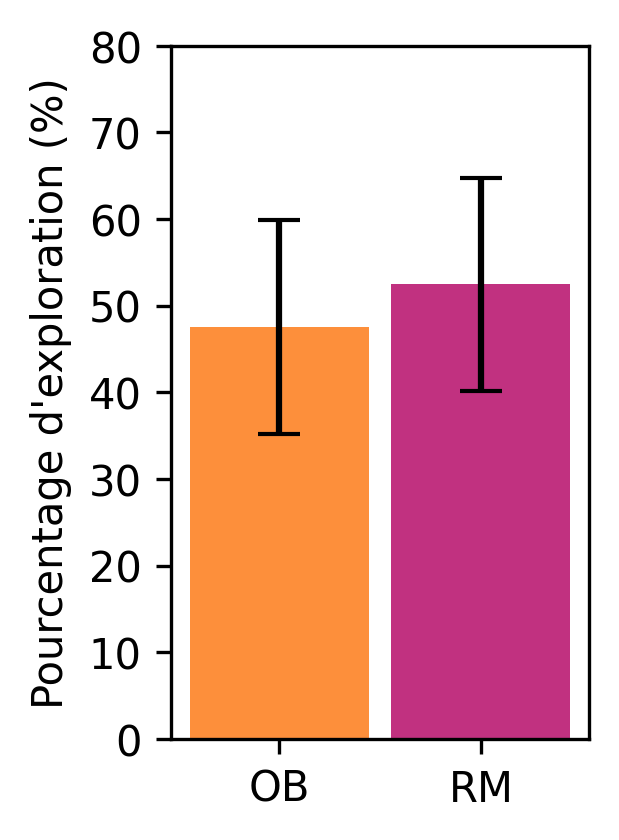

In [125]:
# Function to compute mean and standard error
def calculate_stats(data):
    first_mean = np.mean(data[:, 0])
    first_sem = np.std(data[:, 0], ddof=1)

    second_mean = np.mean(data[:, 1])
    second_sem = np.std(data[:, 1], ddof=1)

    return (first_mean, first_sem), (second_mean, second_sem)

# Calculate statistics
stats = calculate_stats(factor_OB_RM)

# Prepare data for plotting
labels = ['OB', 'RM']
means = [stats[0][0], stats[1][0]]
sems = [stats[0][1], stats[1][1]]

# Plotting
fig, ax = plt.subplots(figsize=(1.8, 3), dpi=300)

x = [0.5,1.4]
width = 0.8  # Width of the bars

# Plot bars with error bars
ax.bar(x, means, width, yerr=sems, capsize=5, color=[NOR_colors[2],NOR_colors[3]])

# Adding labels and title
ax.set_ylabel("Pourcentage d'exploration (%)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 80])

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/finished_figures/novel_objects/RM_OB.svg')

In [129]:
# Extracting RB and BV values from Calib_RB_BV
RB_values = [pair[0] for pair in Calib_RB_BV]
BV_values = [pair[1] for pair in Calib_RB_BV]

# Extracting OB and RM values from Calib_OB_RM
OB_values = [pair[0] for pair in Calib_OB_RM]
RM_values = [pair[1] for pair in Calib_OB_RM]

# Display the extracted lists
print("RB values:", RB_values)
print("BV values:", BV_values)
print("OB values:", OB_values)
print("RM values:", RM_values)

RB values: [30, 42, 42, 30, 15, 30, 14, 30, 26, 30]
BV values: [37, 34, 40, 16, 16, 25, 19, 30, 21, 24]
OB values: [15, 7, 32, 18, 26, 31, 40, 35, 54, 8]
RM values: [23, 7, 23, 23, 31, 33, 43, 18, 43, 32]


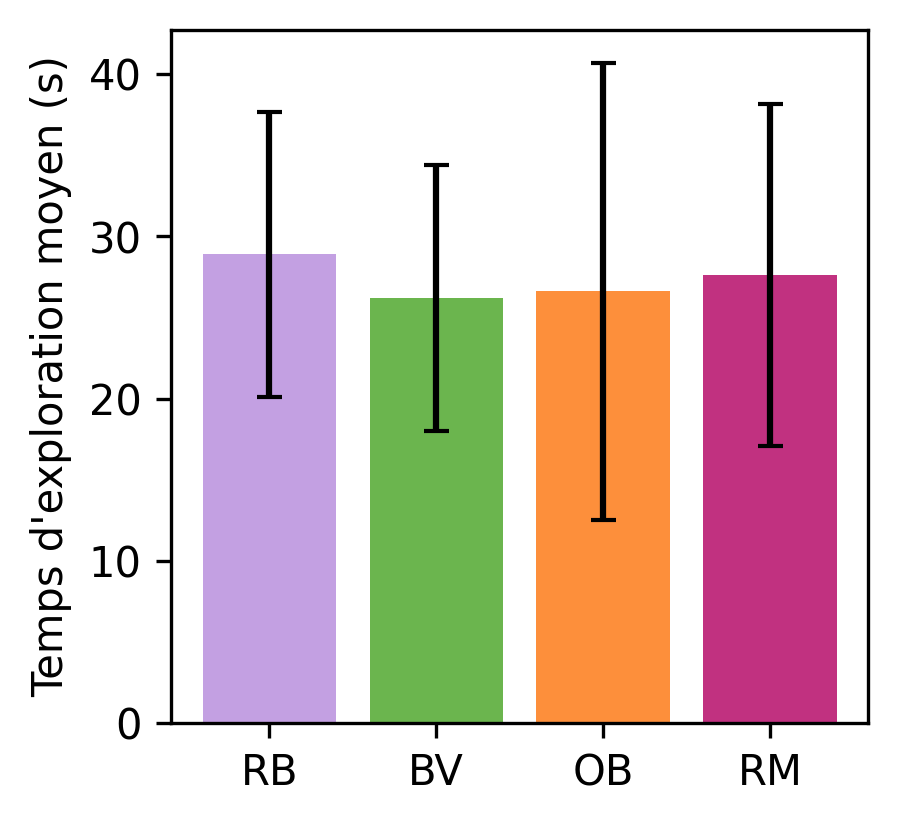

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Calibration datasets
Calib_RB_BV = [(30, 37), (42, 34), (42, 40), (30, 16), (15, 16), (30, 25), (14, 19), (30, 30), (26, 21), (30, 24)]
Calib_OB_RM = [(15, 23), (7, 7), (32, 23), (18, 23), (26, 31), (31, 33), (40, 43), (35, 18), (54, 43), (8, 32)]

NOR_colors = ['#C3A0E2', '#6BB54E', '#FD8F3B', '#C13180']  # RB BV OB RM

# Function to compute total displacement
def calculate_total_displacement(data):
    familiar_total = sum([pair[0] for pair in data])
    new_total = sum([pair[1] for pair in data])
    return familiar_total, new_total

# Calculate total displacements
RB_BV_totals = calculate_total_displacement(Calib_RB_BV)
OB_RM_totals = calculate_total_displacement(Calib_OB_RM)

# Prepare data for plotting
labels = ['RB', 'BV', 'OB', 'RM']
totals = np.array([RB_BV_totals[0], RB_BV_totals[1], OB_RM_totals[0], OB_RM_totals[1]])/10
stds = np.array([np.std(RB_values), np.std(BV_values), np.std(OB_values), np.std(RM_values)])

# Plotting
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

x = [0.5, 1, 1.5, 2]  # Label locations
width = 0.4  # Width of the bars

# Plot bars
ax.bar(x, totals, width, yerr=stds, capsize=3, color=NOR_colors)

# Adding labels and title
ax.set_ylabel("Temps d'exploration moyen (s)")
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/finished_figures/novel_objects/all_total.svg')

plt.show()

# For histograms

In [ ]:
def mean_and_sem(data):
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(len(data))
    return mean, sem

# Calculate mean and SEM for both young and old
young_mean, young_sem = mean_and_sem(young)
old_mean, old_sem = mean_and_sem(old)

# Prepare data for plotting
labels = ['Young', 'Old']
means = [young_mean, old_mean]
sems = [young_sem, old_sem]

# Plotting
fig, ax = plt.subplots(figsize=(2, 3), dpi=300)
x = np.arange(len(labels))  # Label locations
width = 0.75  # Width of the bars

# Create bars with error bars
ax.bar(x, means, width, yerr=sems, capsize=5, color=[colors['blue'],colors['orange']])

# Adding labels and title
ax.set_xlabel('S2+')
ax.set_ylabel('Déplacement total (cm)')
#ax.set_title('Comparison of Mean Values with SEM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, max(means) + max(sems) + 1000])  # Adjust y-axis limit for better visibility

# Show plot
plt.savefig('')


# Déplacement total

In [216]:
def show_coords(coord):
    # Creating a 3x1 subplot layout with more horizontal orientation
    plt.figure(figsize=(12, 6))

    # Plotting x(t)
    plt.subplot(3, 1, 1)
    plt.plot(coord[:,0], color='red')
    plt.title('x(t)')

    # Plotting y(t)
    plt.subplot(3, 1, 2)
    plt.plot(coord[:,1], color='green')
    plt.title('y(t)')

    # Plotting z(t)
    plt.subplot(3, 1, 3)
    plt.plot(coord[:,2], color='blue')
    plt.title('z(t)')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def total_movement(coord):
    # Select x,y only
    coordinates = np.copy(coord[:,:2])
    
    # Calculate the differences between consecutive coordinates
    differences = np.diff(coordinates.astype(np.float32()), axis=0)
    
    # Calculate the Euclidean distance for each pair of points
    distances = np.sqrt(np.sum(differences**2, axis=1))
    
    # Sum up the distances to get the total movement
    total_distance = np.sum(distances)
    
    return total_distance

S_total_mvt = np.zeros(session_stack.shape[2])
M_total_mvt = np.zeros(mouse_stack.shape[2])
for i in range(session_stack.shape[2]):
    S_total_mvt[i] = total_movement(session_stack[:,:,i])
    M_total_mvt[i] = total_movement(mouse_stack[:,:,i])

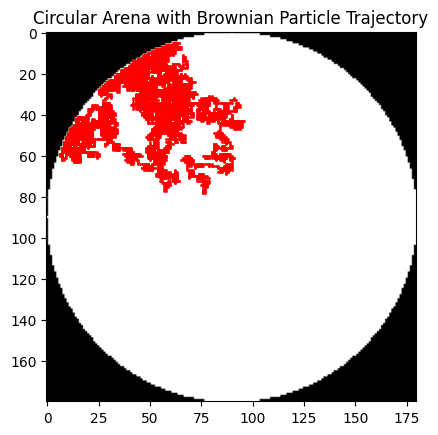

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Define the radius of the arena
radius = 90

# Create a grid that will contain the circular arena
size = radius * 2
grid = np.zeros((size, size), dtype=int)

# Calculate the center of the grid
center = size // 2

# Draw the circular arena
for x in range(size):
    for y in range(size):
        # Calculate the distance from the center
        distance = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        
        # If the distance is less than the radius, mark it as part of the arena
        if distance <= radius:
            grid[x, y] = 1

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.randint(-offset, offset + 1)
    y_position = center + np.random.randint(-offset, offset + 1)
    return x_position, y_position

# Initialize the particle's position within ±30 pixels of the center
particle_position = initialize_particle_position(center)

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# List to store particle positions for plotting
positions = [particle_position]

# Simulate Brownian movement for 10,000 iterations
n_iterations = 10000
for _ in range(n_iterations):
    # Random direction: up, down, left, right
    move = np.random.choice(['up', 'down', 'left', 'right'])
    if move == 'up':
        new_position = (particle_position[0] - 1, particle_position[1])
    elif move == 'down':
        new_position = (particle_position[0] + 1, particle_position[1])
    elif move == 'left':
        new_position = (particle_position[0], particle_position[1] - 1)
    else:  # move == 'right'
        new_position = (particle_position[0], particle_position[1] + 1)

    # Check if the new position is within the arena
    if is_within_arena(new_position[0], new_position[1], center, radius):
        particle_position = new_position
        positions.append(particle_position)

# Plot the circular arena and the particle's trajectory
plt.imshow(grid, cmap='gray')
plt.plot([pos[1] for pos in positions], [pos[0] for pos in positions], 'ro-', markersize=1, linewidth=0.5)  
plt.gca().set_aspect('equal')
plt.title("Circular Arena with Brownian Particle Trajectory")
plt.show()

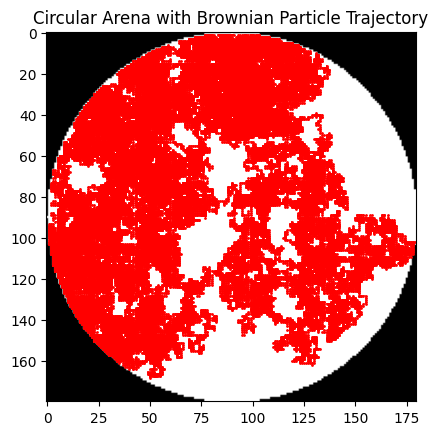

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Define the radius of the arena
radius = 90

# Create a grid that will contain the circular arena
size = radius * 2
grid = np.zeros((size, size), dtype=int)

# Calculate the center of the grid
center = size // 2

# Draw the circular arena
for x in range(size):
    for y in range(size):
        # Calculate the distance from the center
        distance = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        
        # If the distance is less than the radius, mark it as part of the arena
        if distance <= radius:
            grid[x, y] = 1

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.randint(-offset, offset + 1)
    y_position = center + np.random.randint(-offset, offset + 1)
    return x_position, y_position

# Initialize the particle's position within ±30 pixels of the center
particle_position = initialize_particle_position(center)

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# List to store particle positions for plotting
positions = [particle_position]

# Simulate Brownian movement for 10,000 iterations
n_iterations = 100000
for _ in range(n_iterations):
    while True:
        # Random direction: up, down, left, right
        move = np.random.choice(['up', 'down', 'left', 'right'])
        if move == 'up':
            new_position = (particle_position[0] - 1, particle_position[1])
        elif move == 'down':
            new_position = (particle_position[0] + 1, particle_position[1])
        elif move == 'left':
            new_position = (particle_position[0], particle_position[1] - 1)
        else:  # move == 'right'
            new_position = (particle_position[0], particle_position[1] + 1)

        # Check if the new position is within the arena
        if is_within_arena(new_position[0], new_position[1], center, radius):
            particle_position = new_position
            positions.append(particle_position)
            break

# Plot the circular arena and the particle's trajectory
plt.imshow(grid, cmap='gray')
plt.plot([pos[1] for pos in positions], [pos[0] for pos in positions], 'ro-', markersize=1, linewidth=0.5)  
plt.gca().set_aspect('equal')
plt.title("Circular Arena with Brownian Particle Trajectory")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the radius of the arena
radius = 90

# Create a grid that will contain the circular arena
size = radius * 2
grid = np.zeros((size, size), dtype=int)

# Calculate the center of the grid
center = size // 2

# Draw the circular arena
for x in range(size):
    for y in range(size):
        # Calculate the distance from the center
        distance = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        
        # If the distance is less than the radius, mark it as part of the arena
        if distance <= radius:
            grid[x, y] = 1

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Initialize the particle's position within ±30 pixels of the center
particle_position = initialize_particle_position(center)

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# List to store particle positions for plotting
positions = [particle_position]

# Simulate Brownian movement for 10,000 iterations
n_iterations = 18000
step_size = 2.0

for _ in range(n_iterations):
    while True:
        # Random angle between 0 and 2*pi
        angle = np.random.uniform(0, 2 * np.pi)
        
        # Compute the new position using the angle and step size
        new_position = (particle_position[0] + step_size * np.cos(angle),
                        particle_position[1] + step_size * np.sin(angle))

        # Check if the new position is within the arena
        if is_within_arena(new_position[0], new_position[1], center, radius):
            particle_position = new_position
            positions.append(particle_position)
            break

# Plot the circular arena and the particle's trajectory
plt.imshow(grid, cmap='gray')
plt.plot([pos[1] for pos in positions], [pos[0] for pos in positions], 'ro-', markersize=1, linewidth=0.5)  
plt.gca().set_aspect('equal')
plt.title("Circular Arena with Brownian Particle Trajectory")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

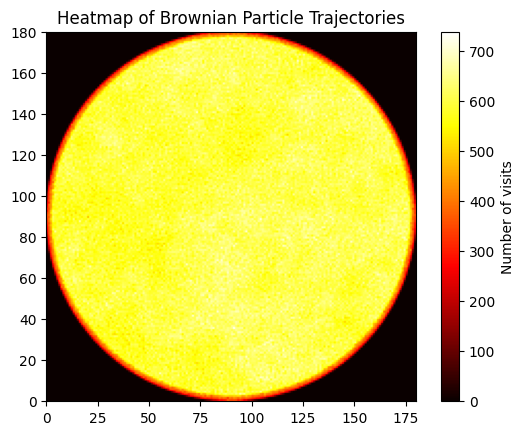

Proportion of time inside 55-pixel radius: 0.38


In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Define the radius of the arena
arena_radius = 90
inner_radius = 55

# Create a grid that will contain the circular arena
size = arena_radius * 2

# Calculate the center of the grid
center = size // 2

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# Function to simulate Brownian movement, update the heatmap, and calculate the proportion
def simulate_brownian_movement(arena_radius, inner_radius, n_iterations=30000, step_size=3.0):
    heatmap = np.zeros((size, size))
    total_within_inner_radius_count = 0

    for _ in tqdm(range(n_simulations)):
        particle_position = initialize_particle_position(center)
        within_inner_radius_count = 0

        for _ in range(n_iterations):
            while True:
                # Random angle between 0 and 2*pi
                angle = np.random.uniform(0, 2 * np.pi)
                
                # Compute the new position using the angle and step size
                new_position = (particle_position[0] + step_size * np.cos(angle),
                                particle_position[1] + step_size * np.sin(angle))

                # Check if the new position is within the arena
                if is_within_arena(new_position[0], new_position[1], center, arena_radius):
                    particle_position = new_position
                    
                    # Update the heatmap
                    x_int, y_int = int(particle_position[0]), int(particle_position[1])
                    heatmap[x_int, y_int] += 1

                    # Check if the new position is within the inner radius
                    if is_within_arena(new_position[0], new_position[1], center, inner_radius):
                        within_inner_radius_count += 1

                    break

        total_within_inner_radius_count += within_inner_radius_count

    proportion_inside_inner_radius = total_within_inner_radius_count / (n_simulations * n_iterations)
    return heatmap, proportion_inside_inner_radius

# Parameters
n_simulations = 500

# Run the simulation to generate the heatmap and calculate the proportion
heatmap, proportion_inside_inner_radius = simulate_brownian_movement(arena_radius, inner_radius)

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', extent=[0, size, 0, size])
plt.colorbar(label='Number of visits')
plt.gca().set_aspect('equal')
plt.title("Heatmap of Brownian Particle Trajectories")
plt.show()

# Print the proportion of time spent inside the inner radius
print(f"Proportion of time inside {inner_radius}-pixel radius: {proportion_inside_inner_radius:.2f}")

In [549]:
velocity_dist = np.zeros(17999*len(session_datainfo[9:]))
for i in range(len(session_datainfo[9:])):
    coords = session_stack[:,:2,i+9]
    velocity_dist[17999*i:((i+1)*17999)] = np.sqrt(np.diff(coords[:,0], axis=0)**2 + np.diff(coords[:,1], axis=0)**2)

100%|███████████████████████████████████████████| 500/500 [03:59<00:00,  2.09it/s]


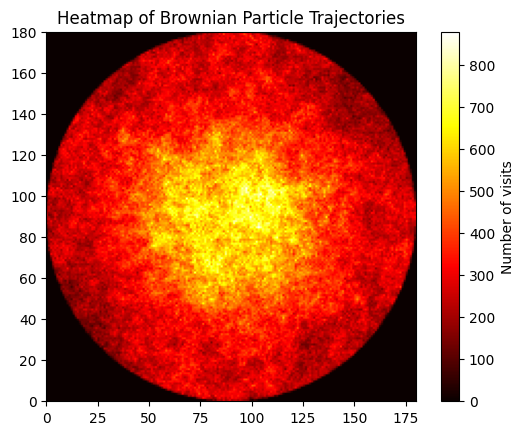

TypeError: unsupported format string passed to list.__format__

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the radius of the arena
arena_radius = 90
inner_radius = 55

n_iterations = 18000
n_simulations = 500

# Create a grid that will contain the circular arena
size = arena_radius * 2

# Calculate the center of the grid
center = size // 2

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# Function to simulate Brownian movement, update the heatmap, and calculate the proportion
def simulate_brownian_movement(arena_radius, inner_radius, step_distribution, n_simulations = n_simulations, n_iterations=18000):
    heatmap = np.zeros((size, size))
    total_within_inner_radius_count = 0
    proportion = []

    for _ in tqdm(range(n_simulations)):
        particle_position = initialize_particle_position(center)
        within_inner_radius_count = 0

        for _ in range(n_iterations):
            while True:
                # Random angle between 0 and 2*pi
                angle = np.random.uniform(0, 2 * np.pi)
                
                # Get a random step size from the input distribution
                step_size = np.random.choice(step_distribution)

                # Compute the new position using the angle and step size
                new_position = (particle_position[0] + step_size * np.cos(angle),
                                particle_position[1] + step_size * np.sin(angle))

                # Check if the new position is within the arena
                if is_within_arena(new_position[0], new_position[1], center, arena_radius):
                    particle_position = new_position
                    
                    # Update the heatmap
                    x_int, y_int = int(particle_position[0]), int(particle_position[1])
                    heatmap[x_int, y_int] += 1

                    # Check if the new position is within the inner radius
                    if is_within_arena(new_position[0], new_position[1], center, inner_radius):
                        within_inner_radius_count += 1

                    break

        proportion_inside_inner_radius = within_inner_radius_count /  n_iterations
        proportion.append(proportion_inside_inner_radius)
        
    return heatmap, proportion




# Run the simulation to generate the heatmap and calculate the proportion
heatmap, proportion_inside_inner_radius = simulate_brownian_movement(arena_radius, inner_radius, velocity_dist)

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', extent=[0, size, 0, size])
plt.colorbar(label='Number of visits')
plt.gca().set_aspect('equal')
plt.title("Heatmap of Brownian Particle Trajectories")
plt.show()

# Print the proportion of time spent inside the inner radius
print(f"Proportion of time inside {inner_radius}-pixel radius: {proportion_inside_inner_radius:.2f}")

# Avec random angles at borders

In [536]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the radius of the arena
arena_radius = 90
inner_radius = 60
mouse_width = 7
max_angle_change = np.pi/3

n_iterations = int(18000/4)
n_simulations = 500

# Create a grid that will contain the circular arena
size = arena_radius * 2

# Calculate the center of the grid
center = size // 2

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# Function to simulate Brownian movement with angle constraint, update the heatmap, and calculate the proportion
def simulate_brownian_movement(arena_radius, inner_radius, step_distribution, max_angle_change=max_angle_change, n_simulations=n_simulations, n_iterations=18000, mouse_width = mouse_width):
    coords = []
    heatmap = np.zeros((size, size))
    total_within_inner_radius_count = 0
    proportion = []

    for _ in tqdm(range(n_simulations)):
        particle_position = initialize_particle_position(center)
        coords.append(particle_position)
        within_inner_radius_count = 0
        previous_angle = np.random.uniform(0, 2 * np.pi)

        for _ in range(n_iterations):
            while True:
                # Random angle change between -max_angle_change and +max_angle_change
                angle_change = np.random.uniform(-max_angle_change, max_angle_change)
                new_angle = previous_angle + angle_change

                # Get a random step size from the input distribution
                step_size = np.random.choice(step_distribution)*4

                # Compute the new position using the new angle and step size
                new_position = (particle_position[0] + step_size * np.cos(new_angle),
                                particle_position[1] + step_size * np.sin(new_angle))

                # Check if the new position is within the arena
                if is_within_arena(new_position[0], new_position[1], center, arena_radius-mouse_width):
                    particle_position = new_position
                    previous_angle = new_angle

                    coords.append(particle_position)
                    
                    # Update the heatmap
                    x_int, y_int = int(particle_position[0]), int(particle_position[1])
                    heatmap[x_int, y_int] += 1

                    # Check if the new position is within the inner radius
                    if is_within_arena(new_position[0], new_position[1], center, inner_radius):
                        within_inner_radius_count += 1

                    break
                
                else:
                    previous_angle = np.random.uniform(0, 2 * np.pi)

        proportion_inside_inner_radius = within_inner_radius_count / n_iterations
        proportion.append(proportion_inside_inner_radius)

    return heatmap, proportion, coords



# Run the simulation to generate the heatmap and calculate the proportion
heatmap, proportion_inside_inner_radius, trajectory = simulate_brownian_movement(arena_radius, inner_radius, velocity_dist)

100%|███████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s]


Proportion of time inside 60-pixel radius: 0.51 +- 0.03


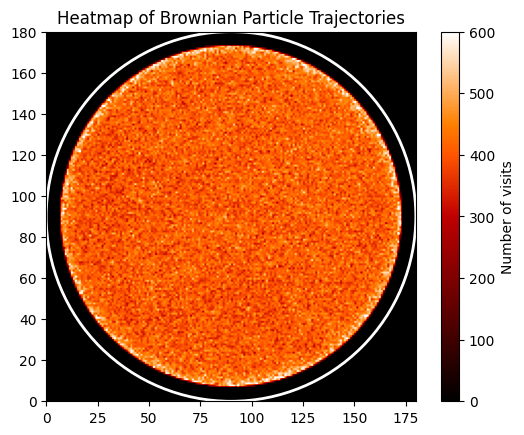

In [560]:
# Plot the heatmap
plt.imshow(heatmap, cmap='gist_heat', extent=[0, size, 0, size], vmin=0,vmax=600)
plt.colorbar(label='Number of visits')
plt.gca().set_aspect('equal')
plt.title("Heatmap of Brownian Particle Trajectories")

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='white', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/heatmap_v4.svg')

# Print the proportion of time spent inside the inner radius
print(f"Proportion of time inside {inner_radius}-pixel radius: {np.mean(proportion_inside_inner_radius):.2f} +- {np.std(proportion_inside_inner_radius):.2f}")

# Sans random angles at borders

100%|███████████████████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]


Proportion of time inside 60-pixel radius: 0.47 +- 0.03


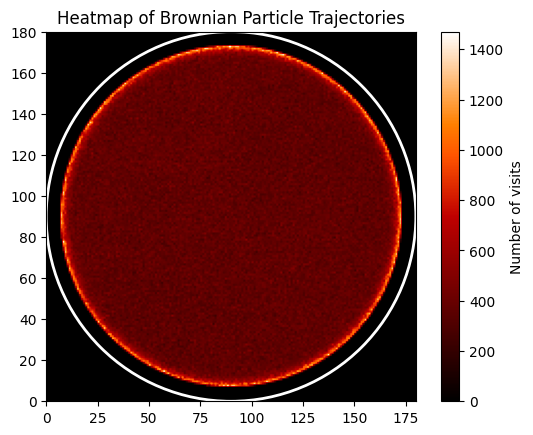

In [543]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the radius of the arena
arena_radius = 90
inner_radius = 60
mouse_width = 7
max_angle_change = np.pi/3

n_iterations = int(18000/4)
n_simulations = 500

# Create a grid that will contain the circular arena
size = arena_radius * 2

# Calculate the center of the grid
center = size // 2

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# Function to simulate Brownian movement with angle constraint, update the heatmap, and calculate the proportion
def simulate_brownian_movement(arena_radius, inner_radius, step_distribution, max_angle_change=max_angle_change, n_simulations=n_simulations, n_iterations=18000, mouse_width = mouse_width):
    coords = []
    heatmap = np.zeros((size, size))
    total_within_inner_radius_count = 0
    proportion = []

    for _ in tqdm(range(n_simulations)):
        particle_position = initialize_particle_position(center)
        coords.append(particle_position)
        within_inner_radius_count = 0
        previous_angle = np.random.uniform(0, 2 * np.pi)

        for _ in range(n_iterations):
            while True:
                # Random angle change between -max_angle_change and +max_angle_change
                angle_change = np.random.uniform(-max_angle_change, max_angle_change)
                new_angle = previous_angle + angle_change

                # Get a random step size from the input distribution
                step_size = np.random.choice(step_distribution)*4

                # Compute the new position using the new angle and step size
                new_position = (particle_position[0] + step_size * np.cos(new_angle),
                                particle_position[1] + step_size * np.sin(new_angle))

                # Check if the new position is within the arena
                if is_within_arena(new_position[0], new_position[1], center, arena_radius-mouse_width):
                    particle_position = new_position
                    previous_angle = new_angle

                    coords.append(particle_position)
                    
                    # Update the heatmap
                    x_int, y_int = int(particle_position[0]), int(particle_position[1])
                    heatmap[x_int, y_int] += 1

                    # Check if the new position is within the inner radius
                    if is_within_arena(new_position[0], new_position[1], center, inner_radius):
                        within_inner_radius_count += 1

                    break
                
#                 else:
#                     previous_angle = np.random.uniform(0, 2 * np.pi)

        proportion_inside_inner_radius = within_inner_radius_count / n_iterations
        proportion.append(proportion_inside_inner_radius)

    return heatmap, proportion, coords



# Run the simulation to generate the heatmap and calculate the proportion
heatmap2, proportion_inside_inner_radius2, trajectory2 = simulate_brownian_movement(arena_radius, inner_radius, velocity_dist)

# Plot the heatmap
plt.imshow(heatmap2, cmap='gist_heat', extent=[0, size, 0, size])
plt.colorbar(label='Number of visits')
plt.gca().set_aspect('equal')
plt.title("Heatmap of Brownian Particle Trajectories")

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='white', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/heatmap_v3.svg')

# Print the proportion of time spent inside the inner radius
print(f"Proportion of time inside {inner_radius}-pixel radius: {np.mean(proportion_inside_inner_radius2):.2f} +- {np.std(proportion_inside_inner_radius2):.2f}")

(0.0, 180.0)

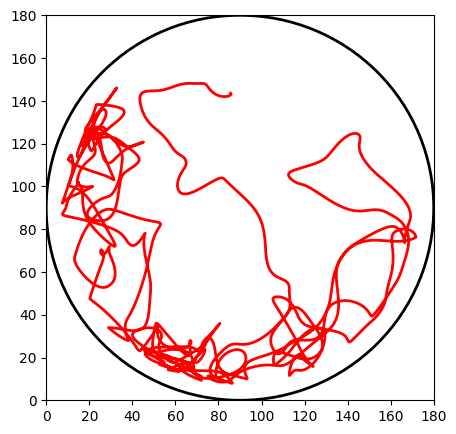

In [546]:
coord2 = np.array(trajectory2)

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(gaussian_filter1d(coord2[2000:4000,0],sigma=3), gaussian_filter1d(coord2[2000:4000,1],sigma=3), linewidth = 2, color='red')

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='black', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

plt.xlim([0,180])
plt.ylim([0,180])

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/trajectory.svg')

100%|█████████████████████████████████████████| 2000/2000 [14:57<00:00,  2.23it/s]


Proportion of time inside 60-pixel radius: 0.53 +- 0.11


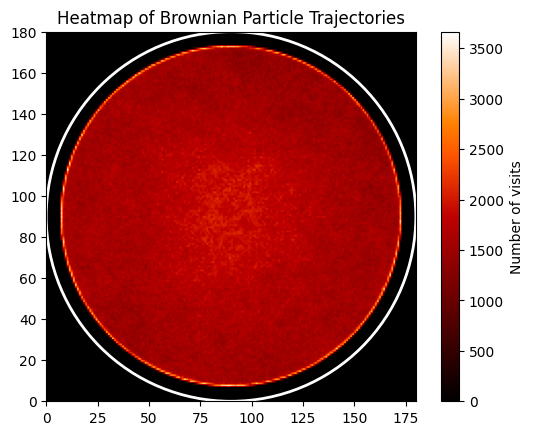

In [552]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the radius of the arena
arena_radius = 90
inner_radius = 60
mouse_width = 7
max_angle_change = np.pi/3

n_iterations = int(18000)
n_simulations = 2000

# Create a grid that will contain the circular arena
size = arena_radius * 2

# Calculate the center of the grid
center = size // 2

# Function to initialize the particle's position
def initialize_particle_position(center, offset=30):
    x_position = center + np.random.uniform(-offset, offset)
    y_position = center + np.random.uniform(-offset, offset)
    return x_position, y_position

# Function to check if a position is within the circular arena
def is_within_arena(x, y, center, radius):
    return np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius

# Function to simulate Brownian movement with angle constraint, update the heatmap, and calculate the proportion
def simulate_brownian_movement(arena_radius, inner_radius, step_distribution, max_angle_change=max_angle_change, n_simulations=n_simulations, n_iterations=18000, mouse_width = mouse_width):
    coords = []
    heatmap = np.zeros((size, size))
    total_within_inner_radius_count = 0
    proportion = []

    for _ in tqdm(range(n_simulations)):
        particle_position = initialize_particle_position(center)
        coords.append(particle_position)
        within_inner_radius_count = 0
        previous_angle = np.random.uniform(0, 2 * np.pi)

        for _ in range(n_iterations):
            while True:
                # Random angle change between -max_angle_change and +max_angle_change
                angle_change = np.random.uniform(-max_angle_change, max_angle_change)
                new_angle = previous_angle + angle_change

                # Get a random step size from the input distribution
                step_size = np.random.choice(step_distribution)

                # Compute the new position using the new angle and step size
                new_position = (particle_position[0] + step_size * np.cos(new_angle),
                                particle_position[1] + step_size * np.sin(new_angle))

                # Check if the new position is within the arena
                if is_within_arena(new_position[0], new_position[1], center, arena_radius-mouse_width):
                    particle_position = new_position
                    previous_angle = new_angle

                    coords.append(particle_position)
                    
                    # Update the heatmap
                    x_int, y_int = int(particle_position[0]), int(particle_position[1])
                    heatmap[x_int, y_int] += 1

                    # Check if the new position is within the inner radius
                    if is_within_arena(new_position[0], new_position[1], center, inner_radius):
                        within_inner_radius_count += 1

                    break
                
#                 else:
#                     previous_angle = np.random.uniform(0, 2 * np.pi)

        proportion_inside_inner_radius = within_inner_radius_count / n_iterations
        proportion.append(proportion_inside_inner_radius)

    return heatmap, proportion, coords



# Run the simulation to generate the heatmap and calculate the proportion
heatmap3, proportion_inside_inner_radius3, trajectory3 = simulate_brownian_movement(arena_radius, inner_radius, velocity_dist)

Proportion of time inside 60-pixel radius: 0.53 +- 0.11


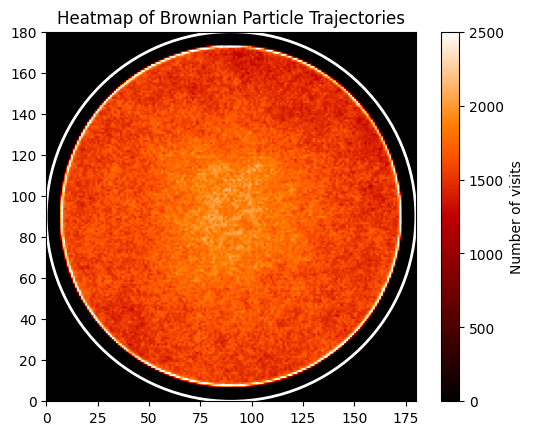

In [556]:

# Plot the heatmap
plt.imshow(heatmap3, cmap='gist_heat', extent=[0, size, 0, size], vmin=0, vmax=2500)
plt.colorbar(label='Number of visits')
plt.gca().set_aspect('equal')
plt.title("Heatmap of Brownian Particle Trajectories")

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='white', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/heatmap_v3.svg')

# Print the proportion of time spent inside the inner radius
print(f"Proportion of time inside {inner_radius}-pixel radius: {np.mean(proportion_inside_inner_radius3):.2f} +- {np.std(proportion_inside_inner_radius3):.2f}")

# Inner / outer with selected regions

In [545]:
# inner / outer
inner = 60
outer = 90
proportion = (1 - (inner**2 / outer**2)) * 100

# Utilisation des f-strings pour formater la chaîne de caractères
formatted_proportion = f"Fraction de l'aire intérieur p/r à l'air total: {proportion:.2f}%"

# Affichage du résultat
print(formatted_proportion)

Fraction de l'aire intérieur p/r à l'air total: 55.56%


# Real data heatmap

In [396]:
session_stack.shape

(18000, 3, 29)

In [406]:
# Reshape session_stack to (18000*33, 3)
trajectories = np.zeros((session_stack.shape[0]*session_stack.shape[2],session_stack.shape[1]))
for i in range(session_stack.shape[2]):
    trajectories[i*session_stack.shape[0]:(i+1)*session_stack.shape[0]] = session_stack[:,:,i]
trajectories = trajectories[:,:2]
print(trajectories.shape)

(522000, 2)


In [544]:
trajectories.shape

(522000, 2)

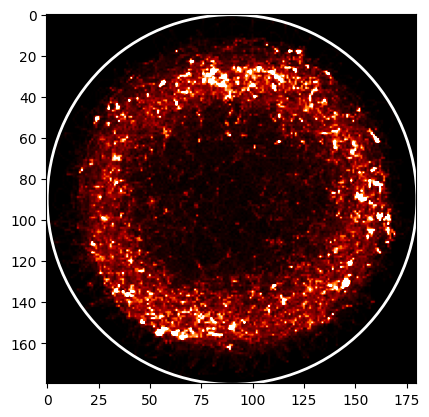

In [449]:
from scipy.ndimage import gaussian_filter

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='white', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

real_heatmap = np.zeros((260,260))
for i in range(trajectories.shape[0]):
    real_heatmap[int(trajectories[i,0]),int(trajectories[i,1])] += 1 
plt.imshow(real_heatmap[38:218, 38:218],vmin=0, vmax=100, cmap='gist_heat')

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/real_heatmap.svg')

In [488]:
coord = np.array(trajectory)

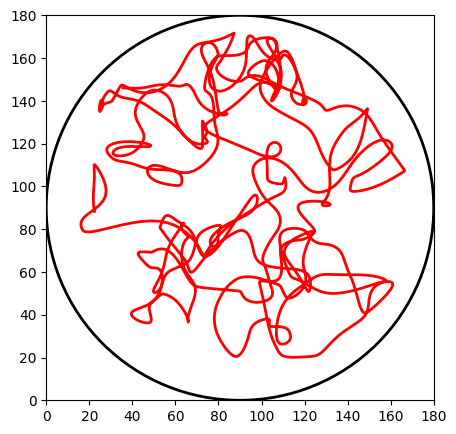

In [529]:
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(gaussian_filter1d(coord[2000:4000,0],sigma=3), gaussian_filter1d(coord[2000:4000,1],sigma=3), linewidth = 2, color='red')

# Add a circle with radius 90 centered on the center of the plot
circle = plt.Circle((90, 90), 90, edgecolor='black', facecolor='none', linewidth=2)
plt.gca().add_artist(circle)

plt.xlim([0,180])
plt.ylim([0,180])

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/trajectory.svg')

# Wall Hugging stats 

In [4]:
def wall_hugging(coords, r, center):


    x, y = coords[:, 0], coords[:, 1]
    cx, cy = center
    
    total_len = coords.shape[0]

    # Calculate the squared distance from the center for each point
    squared_distances = (x - cx)**2 + (y - cy)**2

    # Count the number of points outside the radius
    outside_count = np.sum(squared_distances > r**2)
    
    wall_crawl_ratio = outside_count / total_len * 100

    return wall_crawl_ratio

def wh_stats(stack, r=60, center=[130,130], switching_indexes=[]):
    # Creates a local copy of switching_indexes to avoid modifying the original list
    local_switching_indexes = switching_indexes.copy()
    
    # Appends the total number of data points in the stack to the local copy of the indexes
    local_switching_indexes.append(stack.shape[2])
    
    # Inserts 0 at the start to indicate the beginning of the first session
    local_switching_indexes.insert(0, 0)
    
    n_rows = len(local_switching_indexes) - 1  # The number of sessions is indexes - 1
    len_sessions = np.diff(np.array(local_switching_indexes))
    session_max_len = np.max(len_sessions)
    
    stats = np.zeros((n_rows, session_max_len))  # Initialize the stats array with zeros
    
    data_count = 0
    for session in range(n_rows):
        for n_data in range(session_max_len):
            if n_data >= len_sessions[session]:
                stats[session, n_data] = np.nan  # Fill with NaN if beyond session length
            else:
                # Calculate the wall hugging ratio for valid data points
                stats[session, n_data] = wall_hugging(stack[:, :2, data_count], r=r, center=center)
                data_count += 1  # Increment the data count to move to the next point

    return stats

In [5]:
for i in range(session_stack.shape[2]):
    print(i, '  ', session_datainfo[i]['path'])

0    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1
1    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1
2    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1
3    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1
4    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1
5    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1
6    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1
7    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1
8    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1
9    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2
10    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2
11    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2
12    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2
13    /Users/vincentchouinard/Documents/Maitrise

In [7]:
stats = wh_stats(session_stack, r=60, switching_indexes = [8,16,24])
print(stats)

[[29.15555556 24.21666667 34.3        45.60555556 34.42777778 40.25555556
  38.55       50.57222222         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [37.45555556 75.         52.66111111 52.68888889 72.38333333 62.17777778
  39.23333333 35.17222222         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [51.         47.38333333 65.31111111 69.93333333 74.33888889 80.18888889
  47.41111111 67.67777778         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [79.20555556 38.98333333 39.45       64.91111111 30.47777778 56.83

In [8]:
S1 = stats

In [9]:
S2 = stats[1,:]
S3 = stats[2,:]
S4 = stats[3,:]

In [ ]:
print(np.mean(S2[:4]), '+-', np.std(S2[:4]))
print(np.mean(S2[4:8]), '+-', np.std(S2[4:8]))
print(np.mean(S3[:4]), '+-', np.std(S3[:4]))
print(np.mean(S3[4:8]), '+-', np.std(S3[4:]))
print(np.mean(S4[:3]), '+-', np.std(S4[:3]))
print(np.nanmean(S4[3:]), '+-', np.nanstd(S4[3:]))

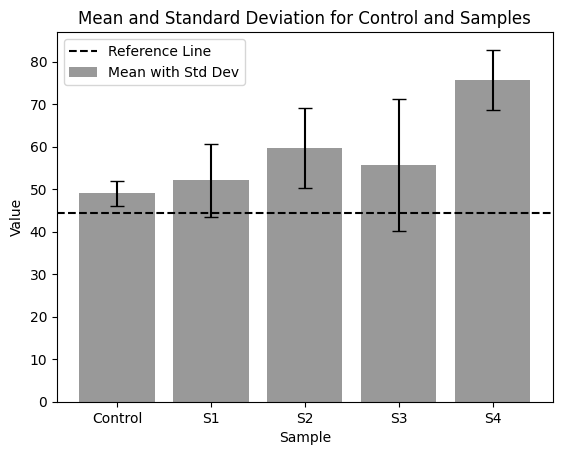

In [732]:
# Recalculating means and standard deviations for S1 to S4
means = np.array([np.nanmean(S) for S in [S1, S2, S3, S4]])
std_devs = np.array([np.nanstd(S) for S in [S1, S2, S3, S4]])

# Control data
control_mean = 49.0
control_std = 3.0

# Adding control bar data at the beginning
updated_means = np.insert(means, 0, control_mean)
updated_std_devs = np.insert(std_devs, 0, control_std)

# Updated labels
updated_labels = ['Control', 'S1', 'S2', 'S3', 'S4']
updated_x = np.arange(len(updated_labels))


# Plotting
fig, ax = plt.subplots()

# Plotting the bars
ax.bar(updated_x, updated_means, yerr=updated_std_devs, capsize=5, color=colors['gray'], label='Mean with Std Dev')

# Adding a horizontal reference line
ax.axhline(y=44.45, color='black', linestyle='--', label='Reference Line')

# Labels and title
ax.set_xlabel('Sample')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation for Control and Samples')
ax.set_xticks(updated_x)
ax.set_xticklabels(updated_labels)
ax.legend()

plt.show()

# Test with more data

In [840]:
for i in range(session_stack.shape[2]):
    print(i, '  ', session_datainfo[i]['path'])
    
stats = wh_stats(session_stack, r=60, switching_indexes = [8,18,28,35,39])

0    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1
1    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1
2    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1
3    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1
4    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1
5    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1
6    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1
7    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1
8    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1
9    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2
10    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2
11    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2
12    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2
13    /Users/vincentchouinard/Documents/Maitrise

In [763]:
import pandas as pd

# Creating a DataFrame for better display
df = pd.DataFrame(stats)
df.index += 1  # Adjusting the index to start from 1

# Displaying the DataFrame with cleaner format
df.style.format("{:.2f}").set_caption("Formatted Data Table")

,0,1,2,3,4,5,6,7,8,9
1,29.16,24.22,34.30,34.43,40.26,38.55,50.57,37.46,nan,nan
2,75.00,52.66,52.69,62.18,39.23,35.17,51.00,47.38,65.31,69.93
3,74.34,80.19,47.41,79.21,38.98,39.45,64.91,30.48,56.84,44.09
4,79.62,84.75,77.47,77.71,72.24,82.61,63.61,nan,nan,nan
5,77.89,53.69,55.66,51.63,nan,nan,nan,nan,nan,nan
6,91.13,89.89,51.92,54.82,nan,nan,nan,nan,nan,nan


In [818]:
good_S1 = wh_stats(session_stack[:,:,:8],r=56,center=[130,130])
print('Habituation data: ',np.round(np.mean(good_S1),2), ' +- ',np.round(np.std(good_S1),2), ' %')

Habituation data:  49.89  +-  7.89  %


In [821]:
good_S2plus = wh_stats(session_stack[:,:,8:],r=60,center=[130,130])
print('S2+ data: ',np.round(np.mean(good_S2plus),2), ' +- ',np.round(np.std(good_S2plus),2), ' %')

S2+ data:  62.03  +-  16.44  %


In [11]:
for i in range(mouse_stack.shape[2]):
    print(i, '  ', mouse_datainfo[i]['path'])

0    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1
1    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2
2    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M28_S3
3    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M28_S4
4    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5
5    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M28_S6
6    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1
7    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2
8    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M29_S3
9    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M29_S4
10    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M29_S5
11    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M29_S6
12    /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1
13    /Users/vincentchouinard/Documents/Maitrise

In [12]:
mice_stats = wh_stats(mouse_stack,r=60,center=[130,130], switching_indexes = [6,12,16,22,26,30,36,39,42,48])

In [13]:
import pandas as pd

# Creating a DataFrame for better display
df = pd.DataFrame(mice_stats)
df.index += 1  # Adjusting the index to start from 1

# Displaying the DataFrame with cleaner format
df.style.format("{:.2f}").set_caption("Formatted Data Table")

,0,1,2,3,4,5
1,29.16,75.00,74.34,79.62,77.89,91.13
2,24.22,52.66,80.19,84.75,53.69,89.89
3,34.30,52.69,47.41,77.47,nan,nan
4,45.61,72.38,67.68,66.19,57.99,67.68
5,15.47,62.18,79.21,77.71,nan,nan
6,40.26,39.23,38.98,72.24,nan,nan
7,34.43,35.17,39.45,82.61,55.66,51.92
8,40.26,51.00,64.91,nan,nan,nan
9,38.55,47.38,30.48,nan,nan,nan
10,50.57,65.31,56.84,63.61,51.63,54.82


In [14]:
young_mice_stats = mice_stats[:6, 1:]
old_mice_stats = mice_stats[6:, 1:]

In [15]:
print(np.nanmean(young_mice_stats.flatten()), ' +- ', np.nanstd(young_mice_stats.flatten()))
print(np.nanmean(old_mice_stats.flatten()), ' +- ', np.nanstd(old_mice_stats.flatten()))

68.25856481481482  +-  14.456988852986902
54.05138888888889  +-  12.998729683304813


In [16]:
mice_means = []
mice_stds = []
for i in range(mice_stats.shape[0]):
    mice_means.append(np.nanmean(mice_stats[i,1:]))
    mice_stds.append(np.nanstd(mice_stats[i,1:]))

[6.077125091909501, 15.867204550484423, 13.105295581970262, 4.687292250540316, 7.698939499057702, 15.618227146651101, 16.652245835262722, 6.955555555555556, 8.45277777777778, 5.213788224920625, 12.919444444444444]


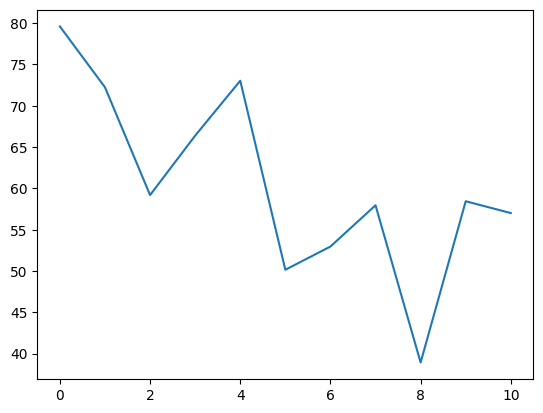

In [17]:
plt.plot(mice_means)
print(mice_stds)

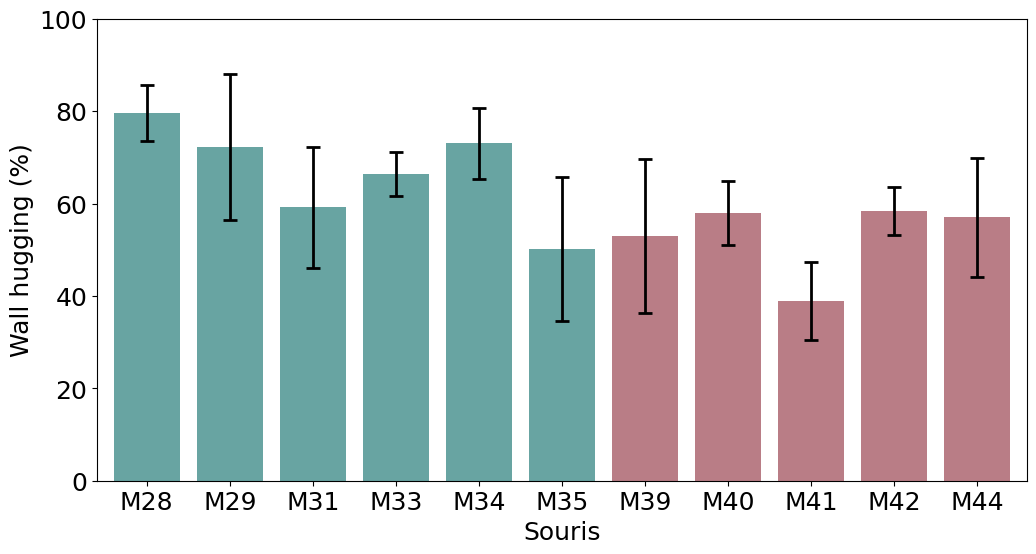

In [93]:
# Set the font size variable at the top to easily adjust for the entire plot
fontsize = 18

# Exclude the first data point (habituation) from each mouse's data
adjusted_mice_stats = mice_stats[:, 1:]

# Recalculate means and standard deviations without the habituation data
adjusted_means = np.nanmean(adjusted_mice_stats, axis=1)
adjusted_stds = np.nanstd(adjusted_mice_stats, axis=1)


mouse_labels = ['M28', 'M29', 'M31', 'M33', 'M34', 'M35', 'M39', 'M40', 'M41', 'M42', 'M44']
bar_positions = np.arange(len(mouse_labels))

plt.figure(figsize=(12, 6))

plt.rc('font', size=fontsize)  # Apply the font size globally

# Create a vertical bar plot with caps and thicker error bars
plt.bar(bar_positions, adjusted_means, yerr=adjusted_stds, alpha=0.6, capsize=5, color=['#046865', '#046865', '#046865', '#046865', '#046865', '#046865', '#8B2635', '#8B2635', '#8B2635', '#8B2635', '#8B2635'],
        error_kw={'elinewidth':2, 'capthick':2})

# Adding labels and title with the specified font size
plt.xlabel('Souris', fontsize=fontsize)
plt.ylabel('Wall hugging (%)', fontsize=fontsize)
#plt.title('Stats of Individual Mice Excluding Habituation with Standard Deviations', fontsize=fontsize)
plt.xticks(bar_positions, mouse_labels, fontsize=fontsize)  # Set mouse labels with specified font size
plt.xlim([-0.6, 10.6])
plt.ylim([0,100])
plt.yticks(fontsize=fontsize)
#plt.legend(fontsize=fontsize)

#plt.grid(True)
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/data.svg')

In [21]:
import pandas as pd

# Creating a DataFrame for better display
df = pd.DataFrame(mice_stats)
df.index += 1  # Adjusting the index to start from 1

# Displaying the DataFrame with cleaner format
df.style.format("{:.2f}").set_caption("Formatted Data Table")

,0,1,2,3,4,5
1,29.16,75.00,74.34,79.62,77.89,91.13
2,24.22,52.66,80.19,84.75,53.69,89.89
3,34.30,52.69,47.41,77.47,nan,nan
4,45.61,72.38,67.68,66.19,57.99,67.68
5,15.47,62.18,79.21,77.71,nan,nan
6,40.26,39.23,38.98,72.24,nan,nan
7,34.43,35.17,39.45,82.61,55.66,51.92
8,40.26,51.00,64.91,nan,nan,nan
9,38.55,47.38,30.48,nan,nan,nan
10,50.57,65.31,56.84,63.61,51.63,54.82


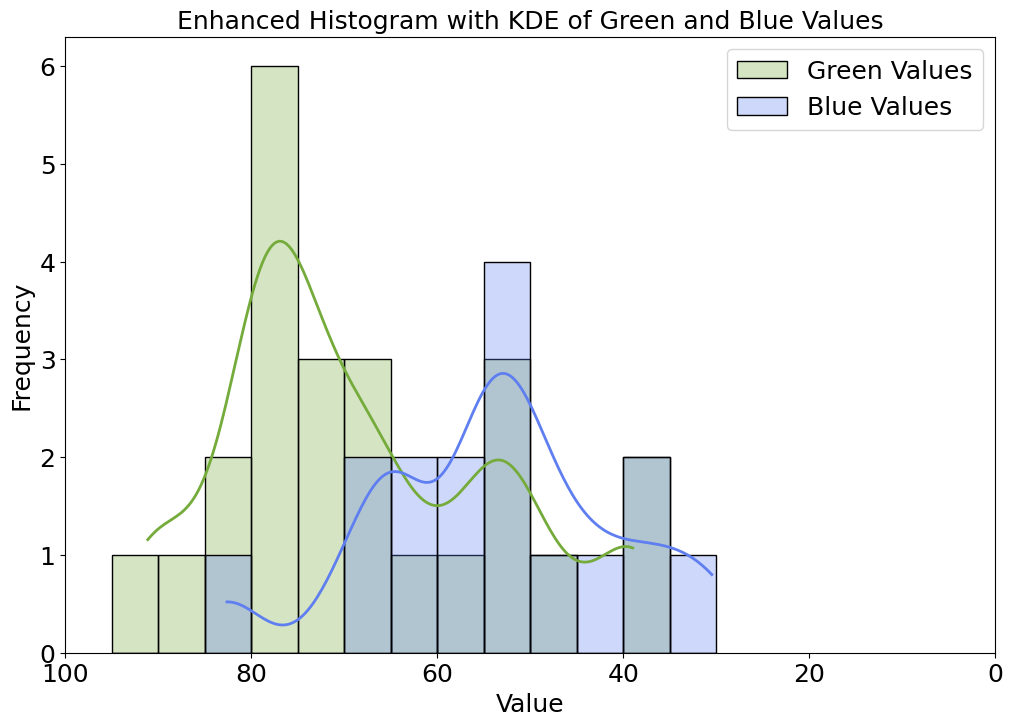

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Create histograms and KDE for green and blue values with less smoothing
sns.histplot(green_values, color='#74AB3A', kde=True, bins=np.arange(30,100,5), label='Green Values', alpha=0.3, line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})
sns.histplot(blue_values, color='#5F7EF0', kde=True, bins=np.arange(30,100,5), label='Blue Values', alpha=0.3, line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Value', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('Enhanced Histogram with KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)


plt.show()

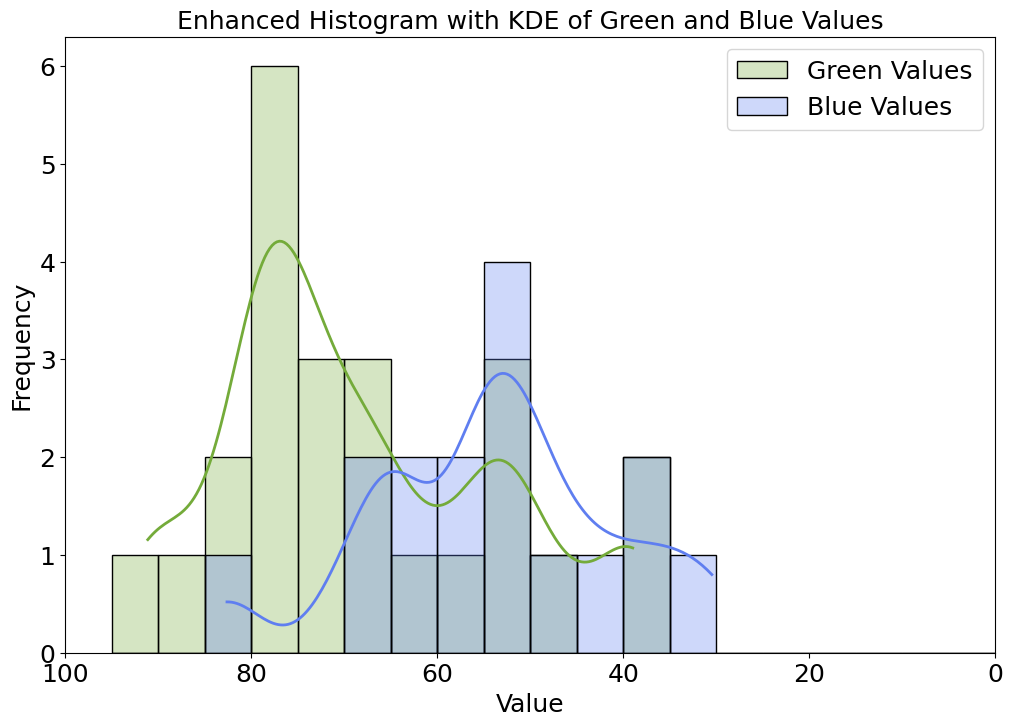

In [941]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

kde_kws = {'bw_adjust': 0.5, 'clip': (0, 100)}

# Create histograms and KDE for green and blue values with less smoothing
sns.histplot(green_values, color='#74AB3A', kde=True, bins=np.arange(0, 100, 5), label='Green Values', alpha=0.3, 
             line_kws={'linewidth': 2}, kde_kws=kde_kws)
sns.histplot(blue_values, color='#5F7EF0', kde=True, bins=np.arange(0, 100, 5), label='Blue Values', alpha=0.3, 
             line_kws={'linewidth': 2}, kde_kws=kde_kws)

# Setting limits and inverting the x-axis to start with high values on the left
plt.xlim([0, 100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Value', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('Enhanced Histogram with KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

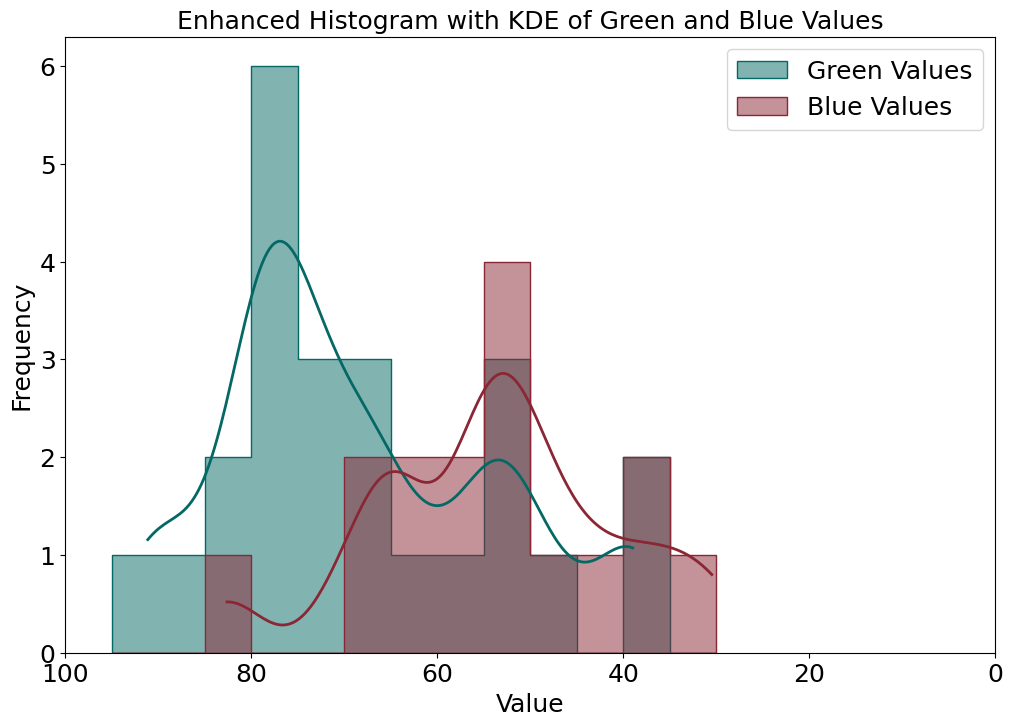

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Create KDE for green and blue values with less smoothing
sns.histplot(green_values, color='#046865', kde=True, element='step', bins=np.arange(30,100,5), label='Green Values', line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})
sns.histplot(blue_values, color='#8B2635', kde=True, element='step', bins=np.arange(30,100,5), label='Blue Values', line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Value', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('Enhanced Histogram with KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

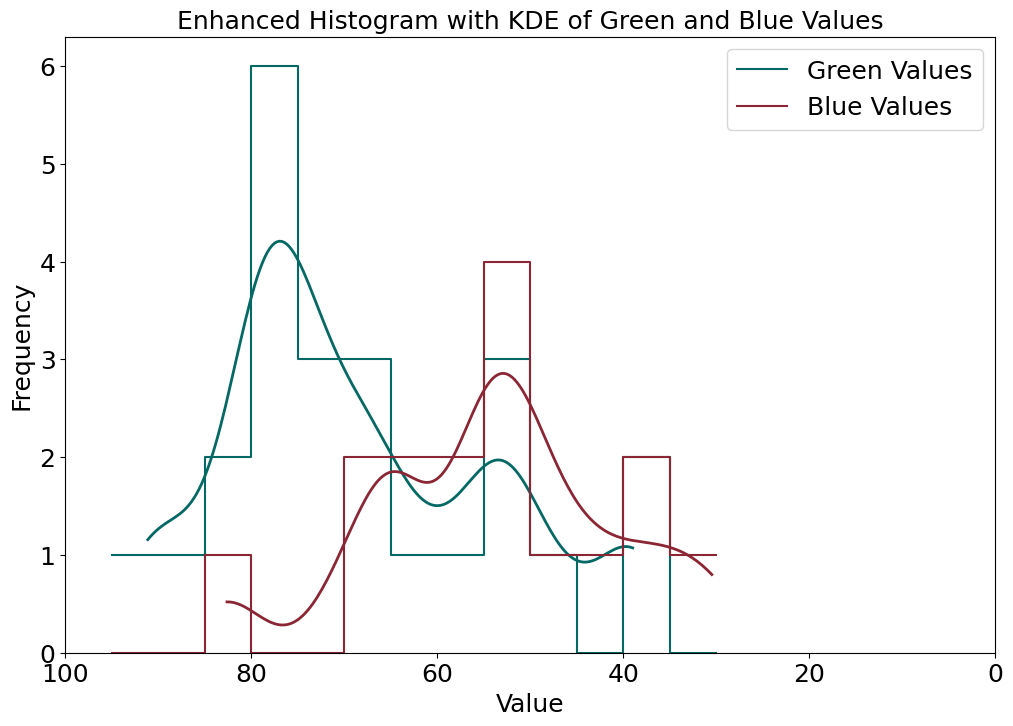

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Create filled KDE for green and blue values with less smoothing
sns.histplot(green_values, color='#046865', kde=True, element='step', fill=False, bins=np.arange(30,100,5), label='Green Values', line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})
sns.histplot(blue_values, color='#8B2635', kde=True, element='step', fill=False, bins=np.arange(30,100,5), label='Blue Values', line_kws={'linewidth': 2}, kde_kws={'bw_adjust': 0.5})

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Value', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.title('Enhanced Histogram with KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.show()

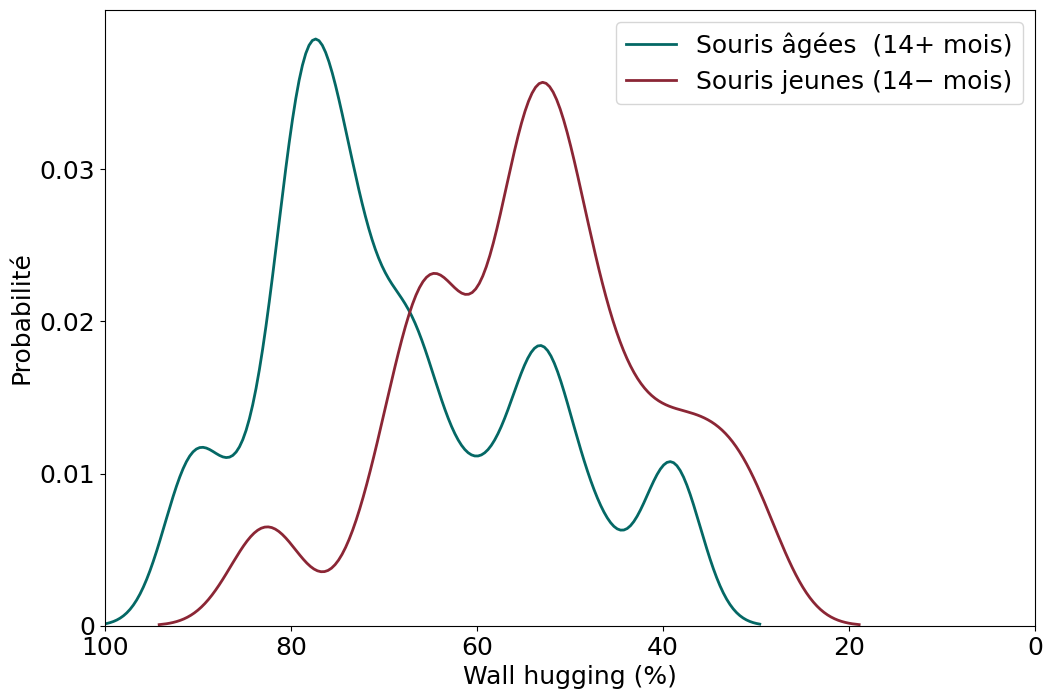

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Plot only KDE lines for green and blue values
sns.kdeplot(green_values, color='#046865', bw_adjust=0.4, label='Souris âgées  (14+ mois)', linewidth=2)
sns.kdeplot(blue_values, color='#8B2635', bw_adjust=0.5, label='Souris jeunes (14− mois)', linewidth=2)

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Wall hugging (%)', fontsize=fontsize)
plt.ylabel('Probabilité', fontsize=fontsize)
plt.yticks([0, 0.01, 0.02,0.03], [0, 0.01,0.02,0.03])
#plt.title('Enhanced KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/density.svg')

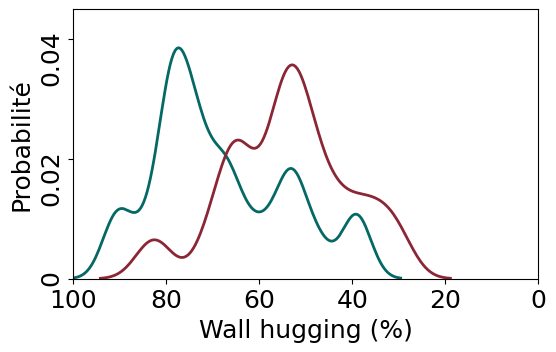

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(6, 3.5))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Plot only KDE lines for green and blue values
sns.kdeplot(green_values, color='#046865', bw_adjust=0.4, label='Souris âgées  (14+ mois)', linewidth=2)
sns.kdeplot(blue_values, color='#8B2635', bw_adjust=0.5, label='Souris jeunes (14− mois)', linewidth=2)

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Wall hugging (%)', fontsize=fontsize)
plt.ylabel('Probabilité', fontsize=fontsize)
plt.yticks([0,  0.02, 0.04], [0, 0.02, 0.04])
plt.ylim([0,0.045])
# Rotate y-axis labels
for label in plt.gca().get_yticklabels():
    label.set_rotation(90)  # Rotate labels to vertical
#plt.legend(fontsize=fontsize)

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/density.svg')
plt.show()

In [99]:
blue_values.shape

(16,)

In [103]:
dist1 = adjusted_means[:6]
dist2 = adjusted_means[6:]

In [106]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(dist1, dist2, equal_var=False)

In [107]:
p_value

0.0393080957444595

In [108]:
!pip install statsmodels

  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/cc/46/b62084c74612a651be78121f3447cb98fa5655341f03af7be4dce4fb86bd/statsmodels-0.14.1-cp38-cp38-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for patsy>=0.5.4 from https://files.pythonhosted.org/packages/43/f3/1d311a09c34f14f5973bb0bb0dc3a6e007e1eda90b5492d082689936ca51/patsy-0.5.6-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 8.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 6.0 MB/s eta 0:00:00ta 0:00:01


In [121]:
fams = adjusted_mice_stats.flatten()
non_nan_adjusted_mice_stats = fams[~np.isnan(fams)]

(40,)

In [125]:
import pandas as pd
import numpy as np

# Example data setup
data = {
    'MouseID': ['M28']*5 + ['M29']*5 + ['M31']*3 + ['M33']*5 + ['M34']*3 + ['M35']*3 + 
               ['M39']*5 + ['M40']*2 + ['M41']*2 + ['M42']*5 + ['M44']*2,
    'Group': ['Old']*24 + ['Young']*16,
    'Value': non_nan_adjusted_mice_stats  # Random values, replace with your actual measurements
}

df = pd.DataFrame(data)
print(df)

   MouseID  Group      Value
0      M28    Old  75.000000
1      M28    Old  74.338889
2      M28    Old  79.622222
3      M28    Old  77.888889
4      M28    Old  91.127778
5      M29    Old  52.661111
6      M29    Old  80.188889
7      M29    Old  84.750000
8      M29    Old  53.688889
9      M29    Old  89.894444
10     M31    Old  52.688889
11     M31    Old  47.411111
12     M31    Old  77.472222
13     M33    Old  72.383333
14     M33    Old  67.677778
15     M33    Old  66.194444
16     M33    Old  57.988889
17     M33    Old  67.677778
18     M34    Old  62.177778
19     M34    Old  79.205556
20     M34    Old  77.711111
21     M35    Old  39.233333
22     M35    Old  38.983333
23     M35    Old  72.238889
24     M39  Young  35.172222
25     M39  Young  39.450000
26     M39  Young  82.611111
27     M39  Young  55.661111
28     M39  Young  51.922222
29     M40  Young  51.000000
30     M40  Young  64.911111
31     M41  Young  47.383333
32     M41  Young  30.477778
33     M42  Yo

In [129]:
import statsmodels.formula.api as smf

# Using a simplified mixed-effects model with only random intercepts for each MouseID
model = smf.mixedlm("Value ~ Group", data=df, groups=df["MouseID"], re_formula=None)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Value    
No. Observations:   40       Method:              REML     
No. Groups:         11       Scale:               176.5699 
Min. group size:    2        Log-Likelihood:      -157.4237
Max. group size:    5        Converged:           Yes      
Mean group size:    3.6                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       67.647    3.642 18.575 0.000  60.509 74.785
Group[T.Young] -13.958    5.609 -2.488 0.013 -24.952 -2.965
Group Var       32.624    3.522                            



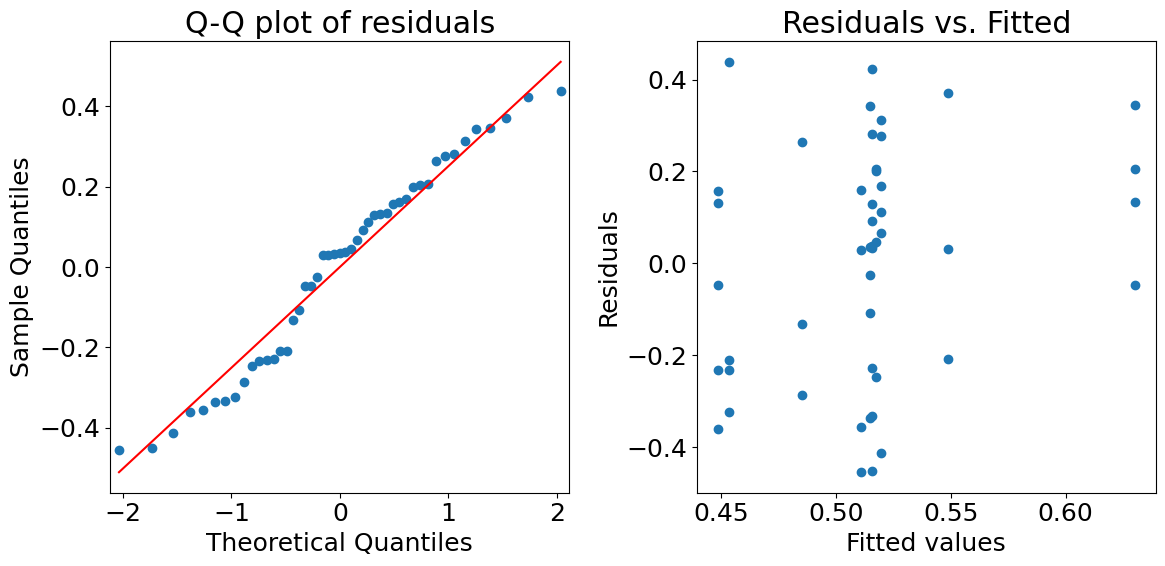

In [111]:
import matplotlib.pyplot as plt

# Plot residuals
res = result.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sm.qqplot(res, line='s', ax=ax[0])  # QQ plot for normality
ax[0].set_title('Q-Q plot of residuals')
ax[1].scatter(result.fittedvalues, res)  # Residuals vs. fitted values plot for homoscedasticity
ax[1].set_title('Residuals vs. Fitted')
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

In [134]:
for i in range(len(session_datainfo[:])):
    print(session_datainfo[i]['path'])

/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2
/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2
/Users/vincentchouinard/Documents/Maitrise/Behav

# Mean velocity in movement

In [168]:
def compute_velocity(coords, sigma):
    velocity = gaussian_filter1d(np.sqrt(np.diff(coords[:,0], axis=0)**2 + np.diff(coords[:,1], axis=0)**2), sigma=sigma)
    velocity = np.append(velocity, velocity[-1])  # Extend to match coords length
    return velocity

def mv_stats(stack, switching_indexes=[]):
    # Creates a local copy of switching_indexes to avoid modifying the original list
    local_switching_indexes = switching_indexes.copy()
    
    # Appends the total number of data points in the stack to the local copy of the indexes
    local_switching_indexes.append(stack.shape[2])
    
    # Inserts 0 at the start to indicate the beginning of the first session
    local_switching_indexes.insert(0, 0)
    
    n_rows = len(local_switching_indexes) - 1  # The number of sessions is indexes - 1
    len_sessions = np.diff(np.array(local_switching_indexes))
    session_max_len = np.max(len_sessions)
    
    stats = np.zeros((n_rows, session_max_len)) # Initialize the stats array with zeros
    
    data_count = 0
    for session in range(n_rows):
        for n_data in range(session_max_len):
            if n_data >= len_sessions[session]:
                stats[session, n_data] = np.nan  # Fill with NaN if beyond session length
            else:
                # Calculate the wall hugging ratio for valid data points
                speed = compute_velocity(stack[:, :, data_count], sigma=3)
                stats[session, n_data] = np.mean(speed[speed > 1.2])
                data_count += 1  # Increment the data count to move to the next point

    return stats

In [170]:
speed_stats = mv_stats(mouse_stack, switching_indexes = [6,12,16,22,26,30,36,39,42,48])

(11, 6)


In [171]:
import pandas as pd

# Creating a DataFrame for better display
df = pd.DataFrame(speed_stats)
df.index += 1  # Adjusting the index to start from 1

# Displaying the DataFrame with cleaner format
df.style.format("{:.2f}").set_caption("Formatted Data Table")

,0,1,2,3,4,5
1,1.96,1.83,1.76,1.67,1.51,1.57
2,1.70,1.65,1.63,1.68,1.47,1.94
3,1.69,1.60,1.75,1.62,nan,nan
4,1.66,1.64,1.71,1.69,1.44,1.43
5,1.44,1.49,1.57,1.49,nan,nan
6,1.44,1.44,1.49,1.46,nan,nan
7,1.78,1.65,1.66,1.56,1.46,1.39
8,1.72,1.63,1.72,nan,nan,nan
9,1.87,1.71,1.84,nan,nan,nan
10,1.96,1.91,1.99,1.91,1.58,1.61


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE

# Assuming adjusted_mice_stats is defined and excludes habituation as before
green_values = adjusted_mice_stats[:6, :].flatten()
blue_values = adjusted_mice_stats[6:, :].flatten()

# Remove NaN values for accurate histogram representation
green_values = green_values[~np.isnan(green_values)]
blue_values = blue_values[~np.isnan(blue_values)]

# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(12, 8))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Plot only KDE lines for green and blue values
sns.kdeplot(green_values, color='#046865', bw_adjust=0.4, label='Souris âgées  (14+ mois)', linewidth=2)
sns.kdeplot(blue_values, color='#8B2635', bw_adjust=0.5, label='Souris jeunes (14− mois)', linewidth=2)

plt.xlim([0,100])
plt.gca().invert_xaxis()

# Adding labels and title
plt.xlabel('Wall hugging (%)', fontsize=fontsize)
plt.ylabel('Probabilité', fontsize=fontsize)
plt.yticks([0, 0.01, 0.02,0.03], [0, 0.01,0.02,0.03])
#plt.title('Enhanced KDE of Green and Blue Values', fontsize=fontsize)
plt.legend(fontsize=fontsize)

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/density.svg')

In [198]:
old_speed = speed_stats[:6,1:].flatten()
nn_old = old_speed[~np.isnan(old_speed)]

In [199]:
young_speed = speed_stats[6:,1:].flatten()
nn_young = young_speed[~np.isnan(young_speed)]

In [203]:
speeds = np.concatenate((nn_old, nn_young),axis=0)

In [202]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(nn_old, nn_young, equal_var=False)
print(p_value)

0.06726998704477047


In [204]:
import pandas as pd
import numpy as np

# Example data setup
data = {
    'MouseID': ['M28']*5 + ['M29']*5 + ['M31']*3 + ['M33']*5 + ['M34']*3 + ['M35']*3 + 
               ['M39']*5 + ['M40']*2 + ['M41']*2 + ['M42']*5 + ['M44']*2,
    'Group': ['Old']*24 + ['Young']*16,
    'Value': speeds  # Random values, replace with your actual measurements
}

df = pd.DataFrame(data)
print(df)

   MouseID  Group     Value
0      M28    Old  1.827955
1      M28    Old  1.763638
2      M28    Old  1.665258
3      M28    Old  1.508587
4      M28    Old  1.572715
5      M29    Old  1.649507
6      M29    Old  1.634873
7      M29    Old  1.678415
8      M29    Old  1.469824
9      M29    Old  1.942409
10     M31    Old  1.600074
11     M31    Old  1.754830
12     M31    Old  1.619947
13     M33    Old  1.638999
14     M33    Old  1.713289
15     M33    Old  1.689144
16     M33    Old  1.439603
17     M33    Old  1.428222
18     M34    Old  1.493636
19     M34    Old  1.574957
20     M34    Old  1.490326
21     M35    Old  1.436262
22     M35    Old  1.493800
23     M35    Old  1.456387
24     M39  Young  1.646458
25     M39  Young  1.664612
26     M39  Young  1.557468
27     M39  Young  1.464742
28     M39  Young  1.389285
29     M40  Young  1.631519
30     M40  Young  1.724404
31     M41  Young  1.713663
32     M41  Young  1.840403
33     M42  Young  1.913997
34     M42  Young  1

In [205]:
import statsmodels.formula.api as smf

# Using a simplified mixed-effects model with only random intercepts for each MouseID
model = smf.mixedlm("Value ~ Group", data=df, groups=df["MouseID"], re_formula=None)
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value  
No. Observations:  40       Method:              REML   
No. Groups:        11       Scale:               0.0168 
Min. group size:   2        Log-Likelihood:      17.2146
Max. group size:   5        Converged:           Yes    
Mean group size:   3.6                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.599    0.041 38.749 0.000  1.518  1.680
Group[T.Young] 0.111    0.064  1.738 0.082 -0.014  0.236
Group Var      0.006    0.041                           



/opt/anaconda3/envs/kinect/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


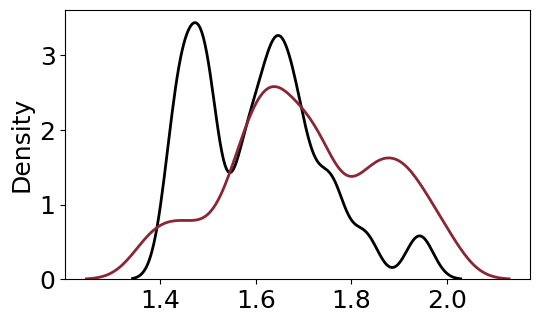

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualization and KDE


# Set the font size for the plot
fontsize = 18
plt.figure(figsize=(6, 3.5))
plt.rc('font', size=fontsize)  # Set the font size for all text in the plot

# Plot only KDE lines for green and blue values
sns.kdeplot(nn_old, color='#046865', bw_adjust=0.4, label='Souris âgées  (14+ mois)', linewidth=2)
sns.kdeplot(nn_young, color='#8B2635', bw_adjust=0.5, label='Souris jeunes (14− mois)', linewidth=2)

#plt.xlim([0,100])
#plt.gca().invert_xaxis()

# Adding labels and title
#plt.xlabel('Wall hugging (%)', fontsize=fontsize)
#plt.ylabel('Probabilité', fontsize=fontsize)
#plt.yticks([0,  0.02, 0.04], [0, 0.02, 0.04])
#plt.ylim([0,0.045])
# Rotate y-axis labels
#for label in plt.gca().get_yticklabels():
# Rotate labels to vertical
#plt.legend(fontsize=fontsize)

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/wallcrawling/density.svg')
plt.show()